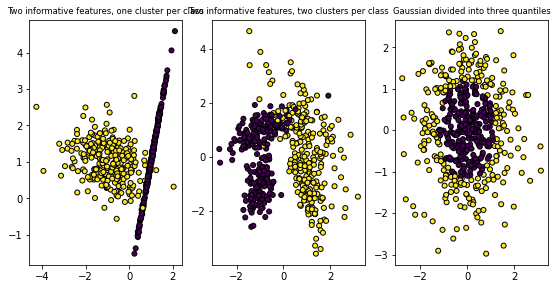

In [74]:
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
plt.figure(figsize=(8, 4))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)


plt.subplot(131)
plt.title("Two informative features, one cluster per class", fontsize='small')
X1, Y1 = make_classification(n_samples=500,n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k')

plt.subplot(132)
plt.title("Two informative features, two clusters per class",
          fontsize='small')
X2, Y2 = make_classification(n_samples=500, n_features=2, 
                             n_redundant=0, 
                             n_informative=2)
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2,
            s=25, edgecolor='k')


plt.subplot(133)
plt.title("Gaussian divided into three quantiles", fontsize='small')
X3, Y3 = make_gaussian_quantiles(n_samples=500,n_features=2, n_classes=2)
plt.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3,
            s=25, edgecolor='k')

plt.show()  # various graphs

In [75]:
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from math import exp

In [76]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split


# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
          correct += 1
    return correct / float(len(actual)) * 100.0


# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Base Learner: SVM

In [77]:
# import section for optimization, plotting  kütüphanelerinin  import edilmesi
import numpy as np    
# For optimization
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize   
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# For generating dataset
import sklearn.datasets as dt
from sklearn.metrics import accuracy_score

In [78]:
import numpy as np

class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    )
                    self.b -= self.lr * y_[idx]
    
    def svm_model(self, train):
        weights = np.array(self.w)
        return weights

    def predict(self, X, y):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

# Meta Learner: Logistic Regression

In [79]:
# Make a prediction with coefficients
def logistic_regression_predict(model, row):
    yhat = model[0]
    for i in range(len(row)-1):
        yhat += model[i + 1] * row[i]
    return 1.0 / (1.0 + exp(-yhat))

# Estimate logistic regression coefficients using stochastic gradient descent
def logistic_regression_model(train, l_rate=0.01, n_epoch=5000):
    coef = [0.0 for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        for row in train:
          yhat = logistic_regression_predict(coef, row)
          error = row[-1] - yhat
          coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)
          for i in range(len(row)-1):
              coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
    return coef

# STACKING

In [80]:
# Make predictions with sub-models and construct a new stacked row
def to_stacked_row(models, predict_list, row):
	stacked_row = list()
	for i in range(len(models)):
		prediction = predict_list[i](models[i], row)
		stacked_row.append(prediction)
	stacked_row.append(row[-1])
	return row[0:len(row)-1] + stacked_row
 

In [81]:
# Stacked Generalization Algorithm
clf = SVM()
def stacking(train, test):
	model_list = [clf.svm_model, clf.svm_model, clf.svm_model]
	predict_list = [clf.predict, clf.predict, clf.predict]
	models = list()
	for i in range(len(model_list)):
		model = model_list[i](train)
		models.append(model)
	stacked_dataset = list()
	for row in train:
		stacked_row = to_stacked_row(models, predict_list, row)
		stacked_dataset.append(stacked_row)
	stacked_model = logistic_regression_model(stacked_dataset)
	predictions = list()
	for row in test:
		stacked_row = to_stacked_row(models, predict_list, row)
		stacked_dataset.append(stacked_row)
		prediction = logistic_regression_predict(stacked_model, stacked_row)
		prediction = round(prediction)
		predictions.append(prediction)
	return predictions

## 1.Veriseti için

In [82]:
# SVM Modelini eğitiriz

clf = SVM()
clf.fit(X1, Y1)

print("1. Sentetik Veriseti için SVM Modeli\n")
predictions = clf.predict(X1, Y1)
print("Accuracy: ", accuracy_score(Y1, predictions)*100, "\n")

1. Sentetik Veriseti için SVM Modeli

Accuracy:  47.8 



In [83]:
# Stackıng için gerekli olan data3'ü elde etmek için X1 ve Y1 değerlerini listeye çeviririz ve data2 olarak birleştiririz

X1 = X1.tolist()
Y1 = Y1.tolist()

data1 = [x + [y] for x, y in zip(X1, Y1)]

In [84]:
clf.svm_model(data1) # Eğitilen modelin ağırlıklarını data3 için kaydederiz

array([-1.8848961 ,  0.55536001])

In [85]:
# stacking kodunun çalışması için tekrardan x1 ve y1'i array formatına getiririz

X1 = np.array(X1)
Y1 = np.array(Y1)

In [86]:
n_folds = 4
scores = evaluate_algorithm(data1, stacking, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [99.2, 99.2, 96.8, 99.2]
Mean Accuracy: 98.600%


## 2.Veriseti için

In [87]:
# SVM Modelini eğitiriz

clf = SVM()
clf.fit(X2, Y2)

print("1. Sentetik Veriseti için SVM Modeli\n")
predictions = clf.predict(X2, Y2)
print("Accuracy: ", accuracy_score(Y2, predictions)*100, "\n")

1. Sentetik Veriseti için SVM Modeli

Accuracy:  46.800000000000004 



In [88]:
# Stackıng için gerekli olan data3'ü elde etmek için X2 ve Y2 değerlerini listeye çeviririz ve data2 olarak birleştiririz

X2 = X2.tolist()
Y2 = Y2.tolist()

data2 = [x + [y] for x, y in zip(X2, Y2)]

In [89]:
clf.svm_model(data2) # Eğitilen modelin ağırlıklarını data3 için kaydederiz

array([1.67013744, 0.13782213])

In [90]:
# stacking kodunun çalışması için tekrardan x2 ve y2'yi array formatına getiririz

X2 = np.array(X2)
Y2 = np.array(Y2)

In [91]:
n_folds = 4
scores = evaluate_algorithm(data2, stacking, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [90.4, 95.19999999999999, 94.39999999999999, 92.0]
Mean Accuracy: 93.000%


## 3.Veriseti için

In [92]:
# SVM Modelini eğitiriz

clf = SVM()
clf.fit(X3, Y3)

print("1. Sentetik Veriseti için SVM Modeli\n")
predictions = clf.predict(X3, Y3)
print("Accuracy: ", accuracy_score(Y3, predictions)*100, "\n")

1. Sentetik Veriseti için SVM Modeli

Accuracy:  17.0 



In [93]:
# Stackıng için gerekli olan data3'ü elde etmek için X3 ve Y3 değerlerini listeye çeviririz ve data3 olarak birleştiririz

X3 = X3.tolist()
Y3 = Y3.tolist()

data3 = [x + [y] for x, y in zip(X3, Y3)]

In [94]:
# Eğitilen modelin ağırlıklarını data3 için kaydederiz
clf.svm_model(data3)

array([-0.51406199,  0.16258528])

In [95]:
# stacking kodunun çalışması için tekrardan x3 ve y3'ü array formatına getiririz
X3 = np.array(X3)
Y3 = np.array(Y3)

In [96]:
n_folds = 4
scores = evaluate_algorithm(data3, stacking, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [47.199999999999996, 34.4, 35.199999999999996, 52.800000000000004]
Mean Accuracy: 42.400%
